In [189]:
import pandas as pd
import numpy as np
import csv
from datetime import datetime

In [190]:
"""
Converts the BOM 2s EDT sounding data to various formats
"""

'\nConverts the BOM 2s EDT sounding data to various formats\n'

In [186]:
def read_csv(csv_ffn, header_line):
    """
    CSV reader used for the radar locations file (comma delimited)
    
    Parameters:
    ===========
        csv_ffn: str
            Full filename to csv file
            
        header_line: int or None
            to use first line of csv as header = 0, use None to use column index
            
    Returns:
    ========
        as_dict: dict
            csv columns are dictionary
    
    """
    df = pandas.read_csv(csv_ffn, header=header_line, skipinitialspace=True)
    as_dict = df.to_dict(orient='list')
    return as_dict

def vappres(t):
    '''
    Returns the vapor pressure of dry air at given temperature
    Parameters
    ------
    t : number, numpy array
        Temperature of the parcel (C)
    Returns
    -------
    Vapor Pressure of dry air
    '''
    pol = t * (1.1112018e-17 + (t * -3.0994571e-20))
    pol = t * (2.1874425e-13 + (t * (-1.789232e-15 + pol)))
    pol = t * (4.3884180e-09 + (t * (-2.988388e-11 + pol)))
    pol = t * (7.8736169e-05 + (t * (-6.111796e-07 + pol)))
    pol = 0.99999683 + (t * (-9.082695e-03 + pol))
    return 6.1078 / pol**8

def mixratio(p, t):
    '''
    Returns the mixing ratio (g/kg) of a parcel
    Parameters
    ----------
    p : number, numpy array
        Pressure of the parcel (hPa)
    t : number, numpy array
        Temperature of the parcel (hPa)
    Returns
    -------
    Mixing Ratio (g/kg) of the given parcel
    '''
    x = 0.02 * (t - 12.5 + (7500. / p))
    wfw = 1. + (0.0000045 * p) + (0.0014 * x * x)
    fwesw = wfw * vappres(t)
    return 621.97 * (fwesw / (p - fwesw))

def vec2comp(wdir, wspd):
    '''
    Underlying function that converts a vector to its components
    Parameters
    ----------
    wdir : number, masked_array
        Angle in meteorological degrees
    wspd : number, masked_array
        Magnitudes of wind vector
    Returns
    -------
    u : number, masked_array (same as input)
        U-component of the wind
    v : number, masked_array (same as input)
        V-component of the wind
    '''
    u = wspd * np.ma.sin(np.radians(wdir)) * -1
    v = wspd * np.ma.cos(np.radians(wdir)) * -1
    return u, v

def find_data_start(ffn):
    """
    This function finds the row where the 2sec header is
    """
    with open(ffn, 'rt') as f:
        data = f.readlines()
    for i, line in enumerate(data):
        if 'SIGNIFICANT LEVELS' in line:
            return i
    return None

In [206]:
output_folder = '/home/meso/Insync/onedrive/sync/projects/Hail/case_studies/20100306-melb/soundings'
csv_ffn = '/home/meso/Insync/onedrive/sync/projects/Hail/case_studies/20100306-melb/soundings/EDT_517149210117535_20100385006518_SIG'

In [207]:
#read header
rows_to_keep = [1,2]
df = pd.read_csv(csv_ffn, skiprows = lambda x: x not in rows_to_keep, header=None)
#get datetime
date_str = '_'.join(df.iloc[0].values[0].split()[3:])
launch_time = datetime.strptime(date_str, '%d/%m/%Y_%H:%M')
#get wmo station
station_id = df.iloc[1].values[0].split()[-1]

#read data
starting_row = find_data_start(csv_ffn) + 3 #offset from header to data
colspecs = [(0, 7), (8, 14), (15, 21), (22, 28), (29, 33), (34, 39), (40, 46), (47, 53)]
df = pd.read_fwf(csv_ffn, header=None, skiprows=starting_row, sep=' ', index_col=None, names=['pres','geop','temp','dwpt','rh','mixr','wnd_dir','wnd_spd'], colspecs=colspecs)
pres = df['pres'].values
geop = df['geop'].values
temp = df['temp'].values
dwpt = df['dwpt'].values
mixr = df['mixr'].values
rh   = df['rh'].values
wnd_dir = df['wnd_dir'].values
wnd_spd = df['wnd_spd'].values

#replace nan
pres[np.isnan(pres)] = -9999
geop[np.isnan(geop)] = -9999
temp[np.isnan(temp)] = -9999
dwpt[np.isnan(dwpt)] = -9999
mixr[np.isnan(mixr)] = -9999
rh[np.isnan(rh)]     = -9999
wnd_dir[np.isnan(wnd_dir)] = -9999
wnd_spd[np.isnan(wnd_spd)] = -9999

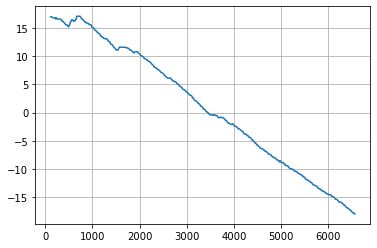

In [208]:
from matplotlib import pyplot as plt

plt.plot(geop[0:500], temp[0:500])
plt.grid()

In [209]:
# #write out - numpy
# oax_ffn = f'{output_folder}/{str(station_id)}_{launch_time.strftime("%Y%m%d_%H%M")}.npz'
# np.savez(oax_ffn, pres=pres, geop=geop, temp=temp, dwpt=dwpt, wnd_dir=wnd_dir, wnd_spd=wnd_spd)

In [210]:
#write out - sharppy OAX

oax_ffn = f'{output_folder}/{str(station_id)}_{launch_time.strftime("%Y%m%d_%H%M")}.oax'

f = open(oax_ffn, 'w')
writer = csv.writer(f)

#write header
writer.writerow(['%TITLE%'])
writer.writerow([f' OAX   {launch_time.strftime("%y%m%d/%H%M")}'])
writer.writerow([])
writer.writerow(['   LEVEL       HGHT       TEMP       DWPT       WDIR       WSPD'])
writer.writerow(['-------------------------------------------------------------------'])
writer.writerow(['%RAW%'])

for i in range(len(pres)):
    writer.writerow([f' {pres[i]:5.2f}',f'  {geop[i]:5.2f}',f'  {temp[i]:5.2f}',f'  {dwpt[i]:5.2f}',f'  {wnd_dir[i]:5.2f}',f'  {wnd_spd[i]:5.2f}'])

#write footer
writer.writerow(['%END%'])
f.close()

In [205]:
# #write out - CM1

# #declare filename
# cm1_ffn = f'{output_folder}/{str(station_id)}_{launch_time.strftime("%Y%m%d_%H%M")}.cm1'

# #contstands
# ROCP = 0.28571426       # R over Cp
# ZEROCNK = 273.15        # Zero Celsius in Kelvins

# #calculate u and v from wind_speed and direction
# u,v = vec2comp(wnd_dir, wnd_spd)

# #calculate theta
# p2 = 1000 #standard reference pressure 
# theta = ((temp + ZEROCNK) * np.power((p2 / pres),ROCP)) - ZEROCNK

# #calculate qv
# qv = mixratio(pres, temp)

# #write header
# writefile=open(cm1_ffn,'w')
# writefile.write(f'{pres[0]:5.2f} {theta[0]:5.2f} {qv[0]:5.2f} \n')

# #write data
# for ii in range(len(geop)):
#         writefile.write(f'{geop[ii]:5.2f} {theta[ii]:5.2f} {qv[ii]:5.2f} {u[ii]:5.2f} {v[ii]:5.2f} \n')
        
# writefile.close()